In [1]:
import sys
import os
root_dir = os.getcwd().replace('/notebooks','')
sys.path.insert(1, root_dir)
import pandas as pd
import ast
import numpy as np
from datetime import datetime as dt
import glob
from zipline.utils.run_algo import load_extensions
from zipline.data import bundles
from zipline.data.data_portal import DataPortal
from zipline.utils.calendar_utils import get_calendar
import os
load_extensions(
    default=True,
    extensions=[],
    strict=True,
    environ=os.environ,
)
from zipline.data.bundles import register, unregister, ingest
from zipline.data.bundles.csvdir import csvdir_equities
from zipline.utils.calendar_utils import register_calendar, get_calendar

from zipline.api import (order, 
                         record, 
                         symbol,
                         get_datetime,
                         order_target_percent,
                         order_target_value,
                         set_benchmark,
                         get_open_orders)
from zipline import run_algorithm
from zipline.utils.calendar_utils import get_calendar
from zipline.api import order_target, record, date_rules, time_rules, symbol
import seaborn as sns
from scipy import stats
from statsmodels.tsa.stattools import coint
import statsmodels.api as sm
import matplotlib.pyplot as plt

import quantstats as qs
import pyfolio as pf
import pandas as pd
import matplotlib.pyplot as plt

In [2]:


def abc(results):
    fig, axes = plt.subplots(4, 1, figsize=(18, 40))

    # Plot Portfolio Value
    axes[0].plot(results.portfolio_value)
    axes[0].set_xlabel("Time")
    axes[0].set_ylabel("Portfolio Value")
    axes[0].set_title("Portfolio Value Over Time")

    # Plot Sharpe Ratio
    axes[1].plot(results.sharpe)
    axes[1].set_xlabel("Time")
    axes[1].set_ylabel("Sharpe Ratio")
    axes[1].set_title("Sharpe Ratio Over Time")

    # Plot Longs Count
    axes[2].plot(results.longs_count)
    axes[2].set_xlabel("Time")
    axes[2].set_ylabel("Longs Count")
    axes[2].set_title("Number of Long Positions Over Time")

    # Plot Shorts Count
    axes[3].plot(results.shorts_count)
    axes[3].set_xlabel("Time")
    axes[3].set_ylabel("Shorts Count")
    axes[3].set_title("Number of Short Positions Over Time")

    plt.tight_layout()
    plt.show()


In [3]:


def plot_trades_per_time(df):
    # Convert the 'period_open' column to a datetime type if it's not already
    df['period_open'] = pd.to_datetime(df['period_open'])

    # Calculate the number of trades per week
    trades_per_week = df.groupby(pd.Grouper(key='period_open', freq='W'))['orders'].count()

    # Calculate the number of trades per month
    trades_per_month = df.groupby(pd.Grouper(key='period_open', freq='M'))['orders'].count()

    # Calculate the number of trades per year
    trades_per_year = df.groupby(pd.Grouper(key='period_open', freq='Y'))['orders'].count()

    # Create line plots
    fig, axes = plt.subplots(3, 1, figsize=(10, 8))

    # Plot trades per week
    axes[0].plot(trades_per_week.index, trades_per_week.values, color='blue')
    axes[0].set_title('Trades per Week')
    axes[0].set_xlabel('Week')
    axes[0].set_ylabel('Number of Trades')

    # Plot trades per month
    axes[1].plot(trades_per_month.index, trades_per_month.values, color='green')
    axes[1].set_title('Trades per Month')
    axes[1].set_xlabel('Month')
    axes[1].set_ylabel('Number of Trades')

    # Plot trades per year
    axes[2].plot(trades_per_year.index, trades_per_year.values, color='red')
    axes[2].set_title('Trades per Year')
    axes[2].set_xlabel('Year')
    axes[2].set_ylabel('Number of Trades')

    # Adjust spacing between subplots
    plt.tight_layout()

    # Show the plots
    plt.show()




In [9]:
bundle = 'quandl'
calendar_name = 'NYSE'
calendar = get_calendar(calendar_name)
bundle_data = bundles.load(bundle)
sids = bundle_data.asset_finder.sids
assets = bundle_data.asset_finder.retrieve_all(sids)
tickers = [coin.symbol for coin in assets]

In [10]:
len(tickers)

3199

In [11]:
df = pd.read_csv('/home/mehedi/Documents/PCA/quant_pca-main/factor1_baskets.csv')
df.head()

,date,longs,shorts
0,2010-01-20,"['EXPE', 'T', 'TMUS', 'ADI', 'WPP']","['PFE', 'PH', 'LNG', 'RF', 'ANTM']"
1,2010-01-21,"['SCCO', 'EXPE', 'CSX', 'WPP', 'TMUS']","['RTN', 'LNG', 'KEY', 'PH', 'RF']"
2,2010-01-22,"['MS', 'SCCO', 'GS', 'IBKR', 'TMUS']","['LNG', 'PFE', 'KEY', 'PH', 'STZ']"
3,2010-01-25,"['SCCO', 'MS', 'KLAC', 'CME', 'NUE']","['KR', 'DAL', 'LNG', 'NBL', 'STZ']"
4,2010-01-26,"['SCCO', 'CME', 'TMUS', 'MS', 'AIG']","['MCO', 'TEL', 'NBL', 'ABC', 'STZ']"


In [12]:
longs_array = df['longs'].apply(ast.literal_eval).values

shorts_array = df['shorts'].apply(ast.literal_eval).values

In [13]:
def initialize(context):
    context.csv = pd.read_csv('/home/mehedi/Downloads/quant_pca-main/factor1_baskets.csv')
    context.idx = 0
    context.longs = context.csv.longs.apply(ast.literal_eval).values
    context.shorts = context.csv.shorts.apply(ast.literal_eval).values
    context.stop_losses = {}
    context.take_profits = {}
    context.actions = []  # List to store trade actions

def handle_data(context, data):
    for long_stocks in context.longs[context.idx]:
        asset = symbol(long_stocks)
        if asset not in context.portfolio.positions:
            order_target_percent(asset=asset, target=.5)
            context.stop_losses[asset] = data.current(asset, 'price') * 0.95
            context.take_profits[asset] = data.current(asset, 'price') * 1.05
            context.actions.append('long')

    for short_stocks in context.shorts[context.idx]:
        asset = symbol(short_stocks)
        if asset not in context.portfolio.positions:
            order_target_percent(asset=asset, target=-.5)
            context.stop_losses[asset] = data.current(asset, 'price') * 1.05
            context.take_profits[asset] = data.current(asset, 'price') * 0.95
            context.actions.append('short')


    context.idx += 1
    record(Action=context.actions[-1])  # Record the last trade action

start = '2010-01-20'
end = '2018-03-27'
capital_base = 100000

results = run_algorithm(
    start=pd.Timestamp(start, tz='utc'),
    end=pd.Timestamp(end, tz='utc'),
    initialize=initialize,
    handle_data=handle_data,
    capital_base=capital_base,
    trading_calendar=calendar,
    bundle=bundle,
    data_frequency='daily'
)

FileNotFoundError: [Errno 2] No such file or directory: '/home/mehedi/Downloads/quant_pca-main/factor1_baskets.csv'

<AxesSubplot:>

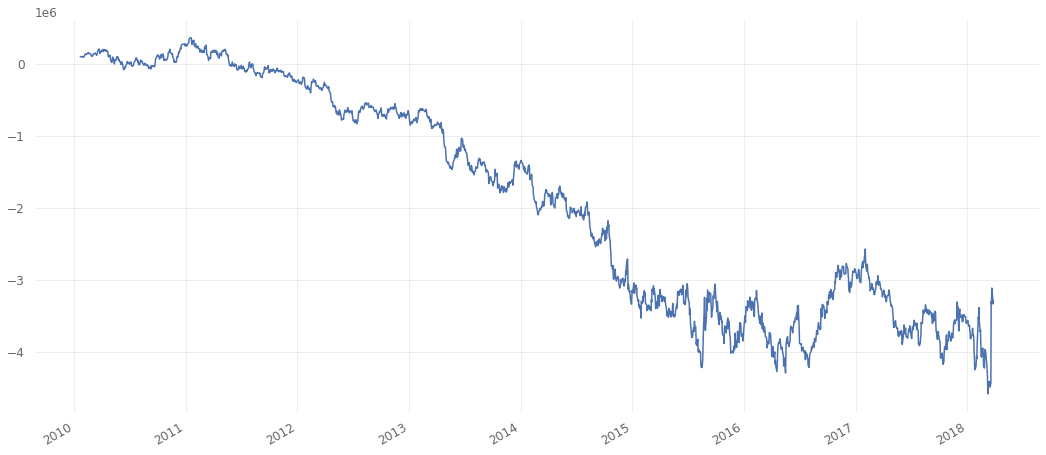

In [ ]:
results.portfolio_value.plot(figsize=(18,8))

<AxesSubplot:>

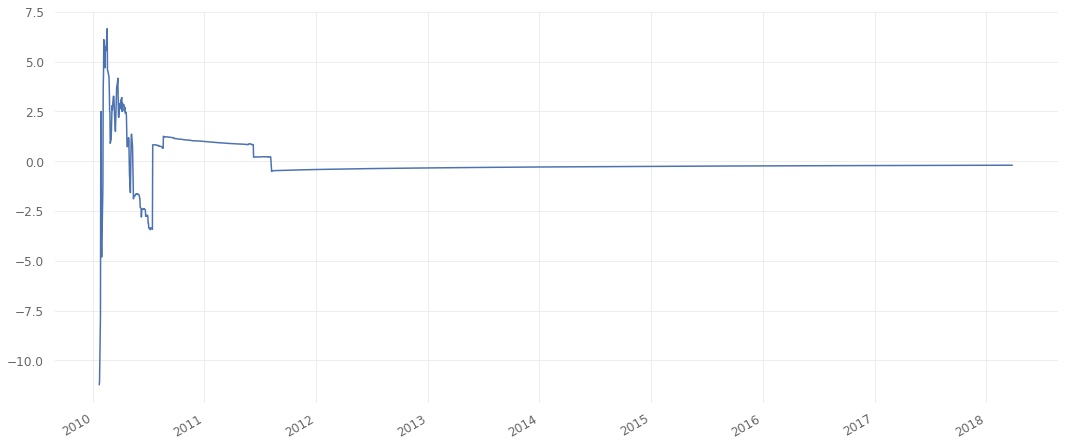

In [ ]:
results.sharpe.plot(figsize=(18,8))

In [ ]:
results.to_csv('/home/mehedi/Downloads/quant_pca-main/result8.csv',index=False)

In [ ]:
def initialize(context):
    context.csv = pd.read_csv('/home/mehedi/Downloads/quant_pca-main/factor1_baskets.csv')
    context.idx = 0
    context.longs = context.csv.longs.apply(ast.literal_eval).values
    context.shorts = context.csv.shorts.apply(ast.literal_eval).values
    context.stop_losses = {}
    context.take_profits = {}
    context.actions = []  # List to store trade actions

def handle_data(context, data):
    for long_stocks in context.longs[context.idx]:
        asset = symbol(long_stocks)
        if asset not in context.portfolio.positions:
            order_target_percent(asset=asset, target=1)
            context.actions.append('long')

    for short_stocks in context.shorts[context.idx]:
        asset = symbol(short_stocks)
        if asset not in context.portfolio.positions:
            order_target_percent(asset=asset, target=0)
            context.actions.append('short')


    context.idx += 1
    record(Action=context.actions[-1])  # Record the last trade action

start = '2010-01-20'
end = '2018-03-27'
capital_base = 100000

results = run_algorithm(
    start=pd.Timestamp(start, tz='utc'),
    end=pd.Timestamp(end, tz='utc'),
    initialize=initialize,
    handle_data=handle_data,
    capital_base=capital_base,
    trading_calendar=calendar,
    bundle=bundle,
    data_frequency='daily'
)

<AxesSubplot:>

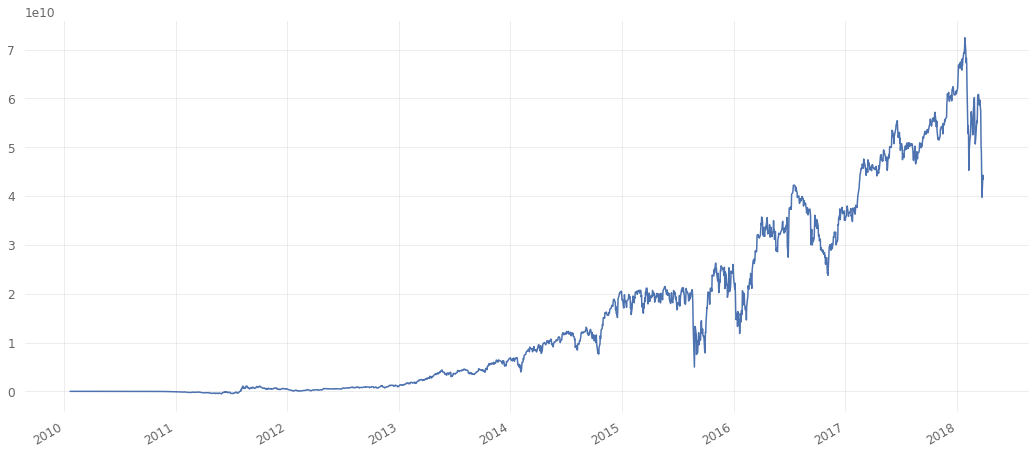

In [ ]:
results.portfolio_value.plot(figsize=(18,8))

<AxesSubplot:>

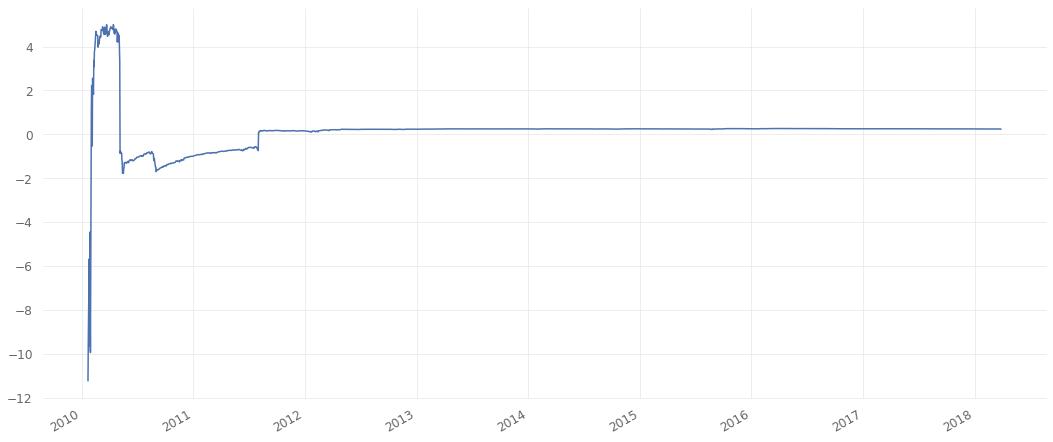

In [ ]:
results.sharpe.plot(figsize=(18,8))

In [ ]:
results.to_csv('/home/mehedi/Downloads/quant_pca-main/result10.csv',index=False)

now I want to add only take profit with this

In [14]:
def initialize(context):
    context.csv = pd.read_csv('/home/mehedi/Documents/PCA/quant_pca-main/factor1_baskets.csv')
    context.idx = 0
    context.longs = context.csv.longs.apply(ast.literal_eval).values
    context.shorts = context.csv.shorts.apply(ast.literal_eval).values
    context.stop_losses = {}
    context.take_profits = {}
    context.actions = []  # List to store trade actions
    context.long = 0
    context.short = 0
    context.stop_loss = 0
    context.take_profit = 0
    

def handle_data(context, data):
   
    
    for long_stocks in context.longs[context.idx]:
        asset = symbol(long_stocks)
        order_target_percent(asset, 0.1)  # Buy 10% of portfolio value
        context.stop_losses[asset] = data.current(asset, 'price') * 0.98
        context.take_profits[asset] = data.current(asset, 'price') * 1.04
    
        context.long += 1
         
    for short_stocks in context.shorts[context.idx]:
        asset = symbol(short_stocks)
        order_target_percent(asset, -0.1)  # Sell short 10% of portfolio value
        context.stop_losses[asset] = data.current(asset, 'price') * 0.96   #working like take-profit
        context.take_profits[asset] = data.current(asset, 'price') * 1.02  #working like stoploss  
        
        context.short +=1
    
    for asset in context.portfolio.positions:
        current_price = data.current(asset, 'price')
        if asset in context.stop_losses and current_price <= context.stop_losses[asset]:
            order_target_percent(asset=asset, target=0)
            context.stop_loss +=1
            del context.stop_losses[asset]
            del context.take_profits[asset]
            
        if asset in context.take_profits and current_price >= context.take_profits[asset]:
            order_target_percent(asset=asset, target=0)
            context.take_profit +=1
            del context.stop_losses[asset]
            del context.take_profits[asset]
              

    context.idx += 1
    print ('long =', context.long, 'short=', context.short, 'take-profit=', context.take_profit, 'stop_loss=', context.stop_loss)
    

start = '2010-01-20'
end = '2018-03-27'
capital_base = 100000

results = run_algorithm(
    start=pd.Timestamp(start, tz='utc'),
    end=pd.Timestamp(end, tz='utc'),
    initialize=initialize,
    handle_data=handle_data,
    capital_base=capital_base,
    trading_calendar=calendar,
    bundle=bundle,
    data_frequency='daily'
)


long = 5 short= 5 take-profit= 0 stop_loss= 0
long = 10 short= 10 take-profit= 0 stop_loss= 0
long = 15 short= 15 take-profit= 0 stop_loss= 4
long = 20 short= 20 take-profit= 0 stop_loss= 5
long = 25 short= 25 take-profit= 0 stop_loss= 9
long = 30 short= 30 take-profit= 1 stop_loss= 9
long = 35 short= 35 take-profit= 1 stop_loss= 10
long = 40 short= 40 take-profit= 2 stop_loss= 13
long = 45 short= 45 take-profit= 3 stop_loss= 13
long = 50 short= 50 take-profit= 5 stop_loss= 13
long = 55 short= 55 take-profit= 6 stop_loss= 14
long = 60 short= 60 take-profit= 6 stop_loss= 30
long = 65 short= 65 take-profit= 7 stop_loss= 30
long = 70 short= 70 take-profit= 7 stop_loss= 30
long = 75 short= 75 take-profit= 9 stop_loss= 31
long = 80 short= 80 take-profit= 12 stop_loss= 31
long = 85 short= 85 take-profit= 16 stop_loss= 31
long = 90 short= 90 take-profit= 20 stop_loss= 31
long = 95 short= 95 take-profit= 24 stop_loss= 31
long = 100 short= 100 take-profit= 28 stop_loss= 31
long = 105 short= 105

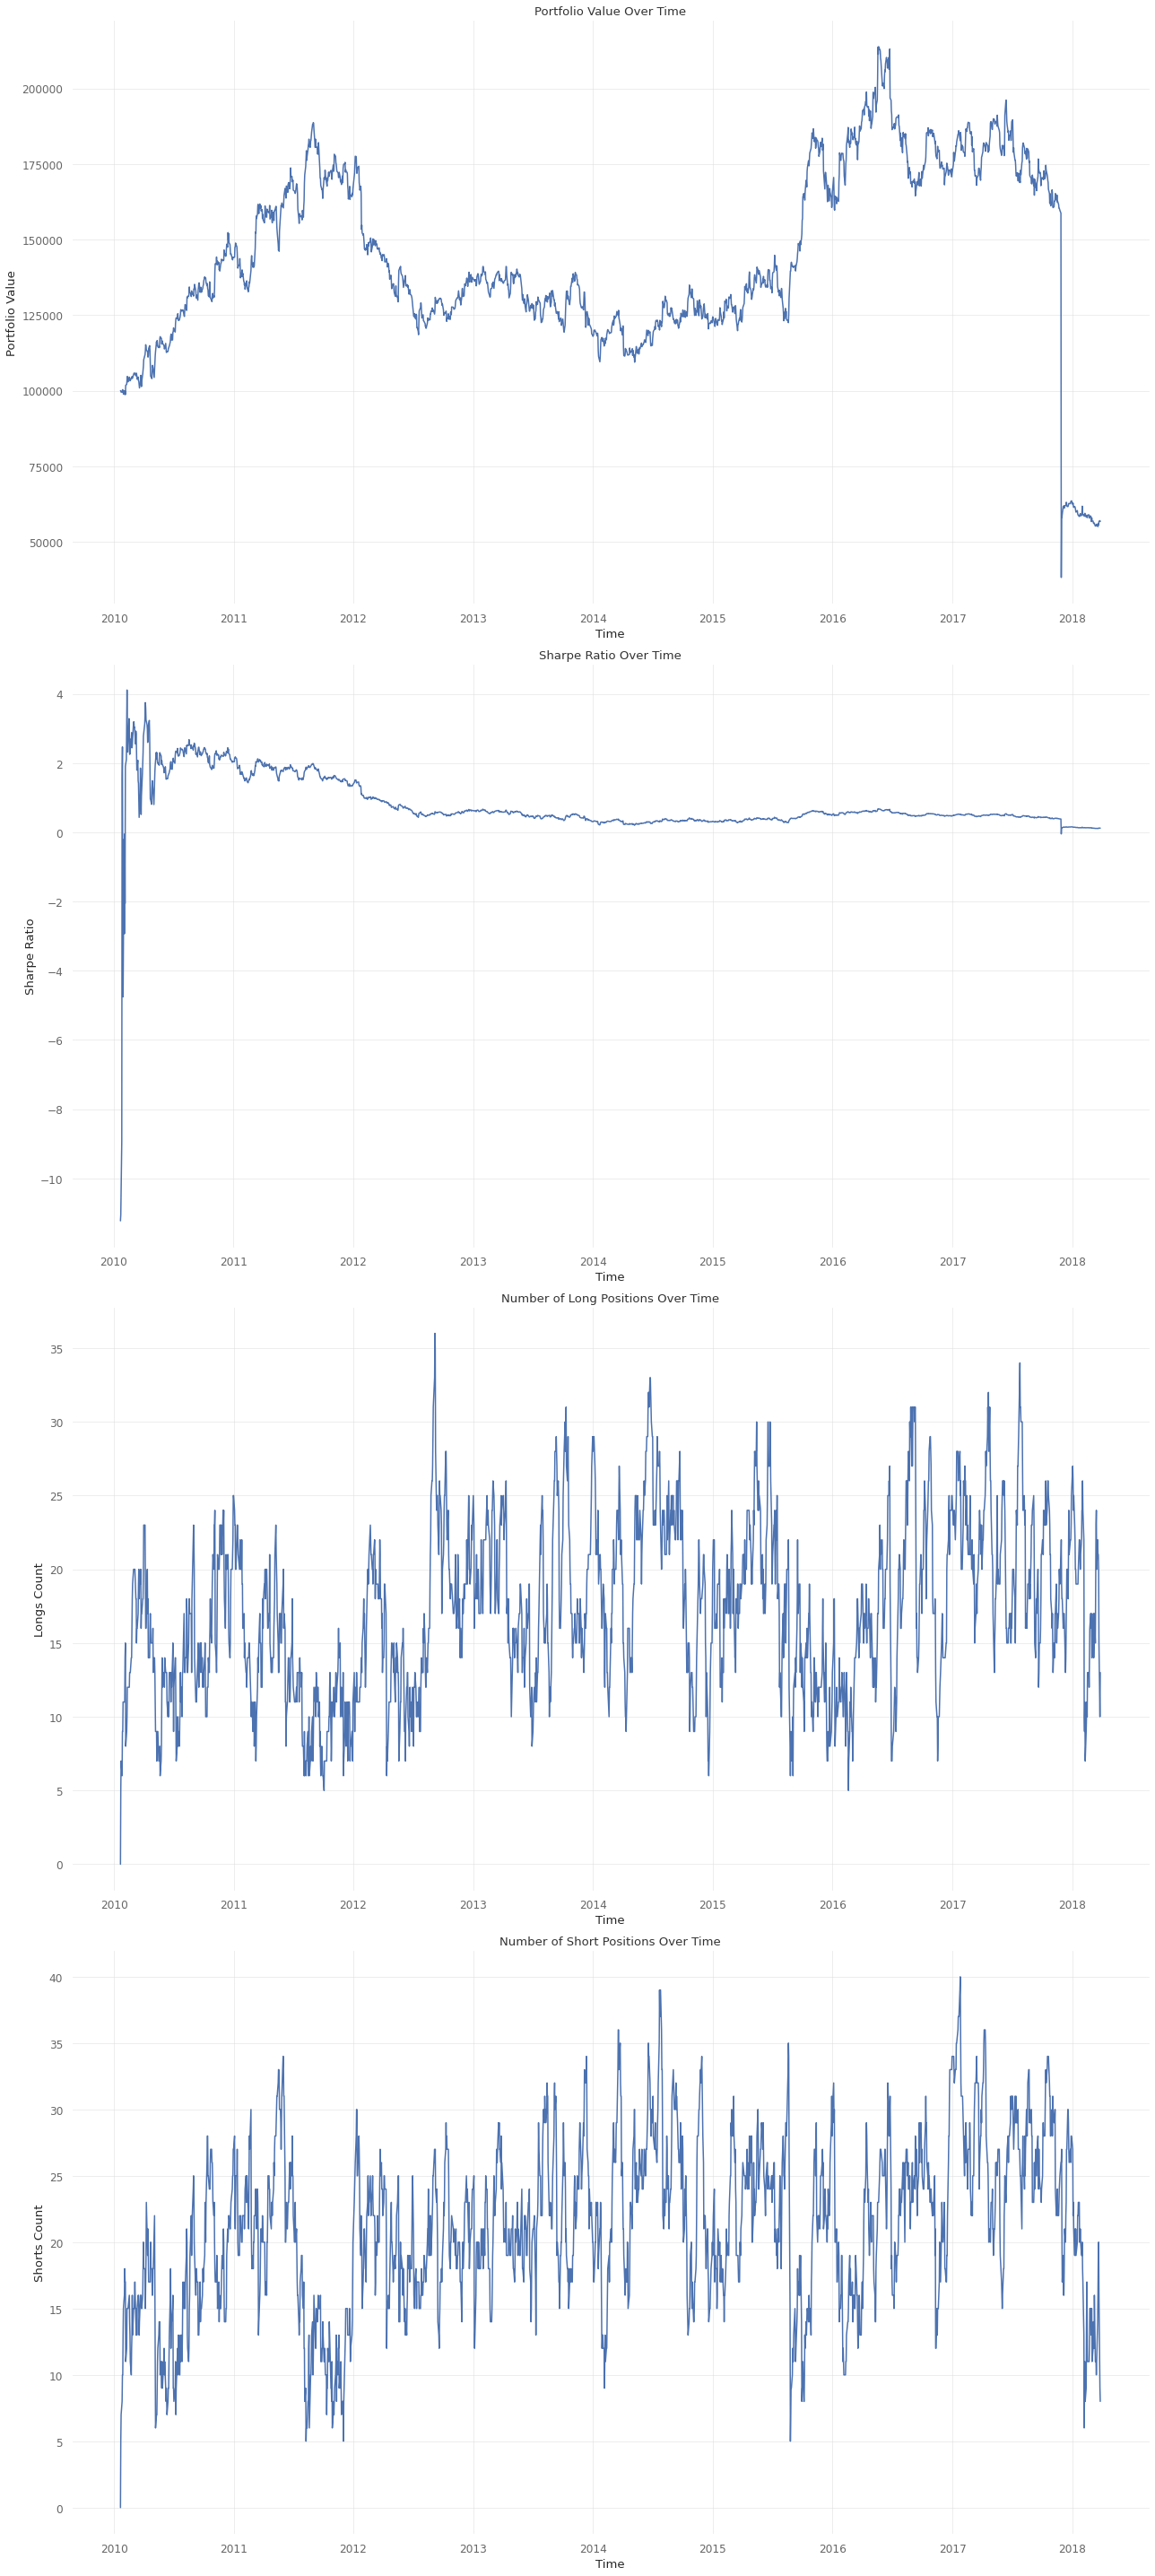

In [15]:
abc(results)

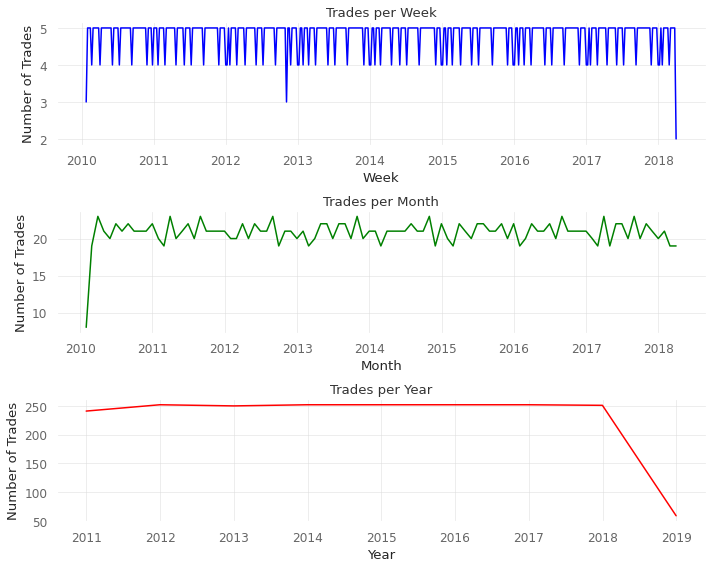

In [16]:
plot_trades_per_time(results)

                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2010-01-21  2010-01-21
End Period                 2018-03-27  2018-03-27
Risk-Free Rate             0.0%        0.0%
Time in Market             100.0%      35.0%

Cumulative Return          -43.32%     149.27%
CAGR﹪                     -6.7%       11.81%

Sharpe                     0.12        1.09
Prob. Sharpe Ratio         63.12%      99.99%
Smart Sharpe               0.09        0.78
Sortino                    0.16        2.06
Smart Sortino              0.11        1.47
Sortino/√2                 0.11        1.46
Smart Sortino/√2           0.08        1.04
Omega                      1.04        1.04

Max Drawdown               -82.14%     -13.73%
Longest DD Days            1671        616
Volatility (ann.)          38.79%      10.73%
R^2                        0.0         0.0
Information Ratio          -0.01       -0.01
Calmar                     -0.08      

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2016-05-23,2017-11-28,2018-03-27,673,-82.142183,-74.098314
2,2011-09-01,2014-05-07,2016-03-29,1671,-42.017738,-40.760776
3,2010-12-15,2011-02-14,2011-03-08,83,-12.861669,-12.298286
4,2011-06-24,2011-07-19,2011-08-08,45,-10.580047,-9.913497
5,2010-04-08,2010-04-26,2010-05-10,32,-9.739059,-9.406594


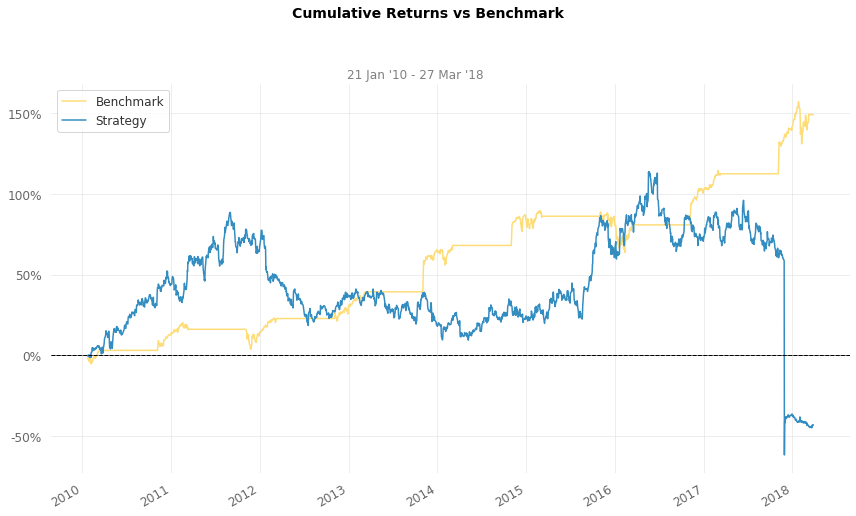

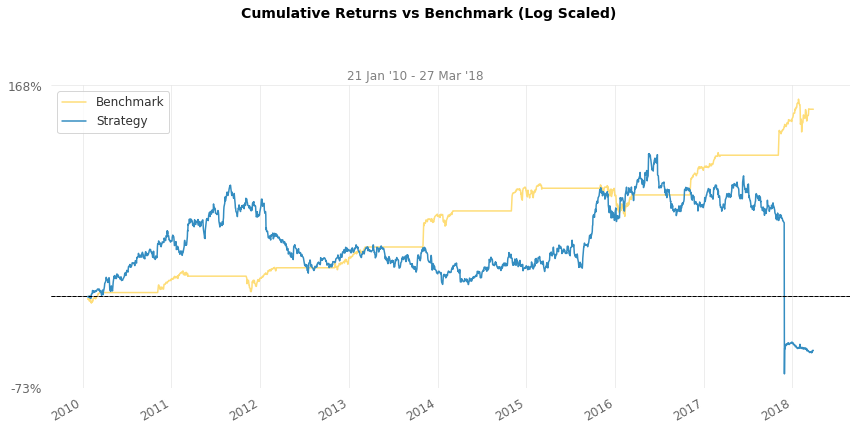

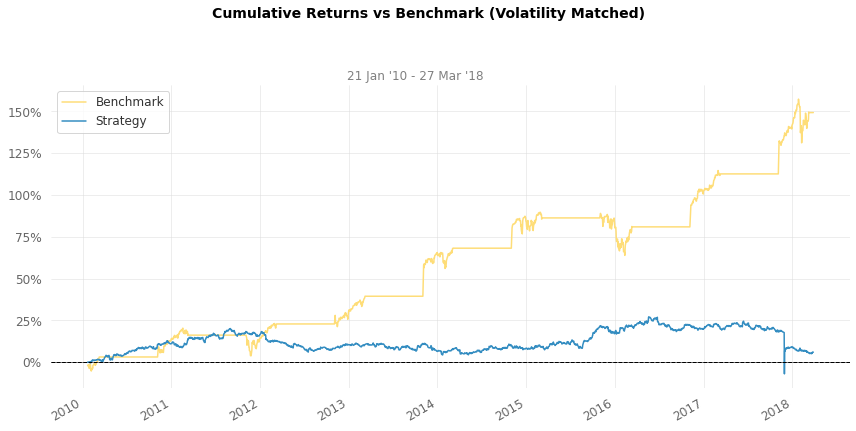

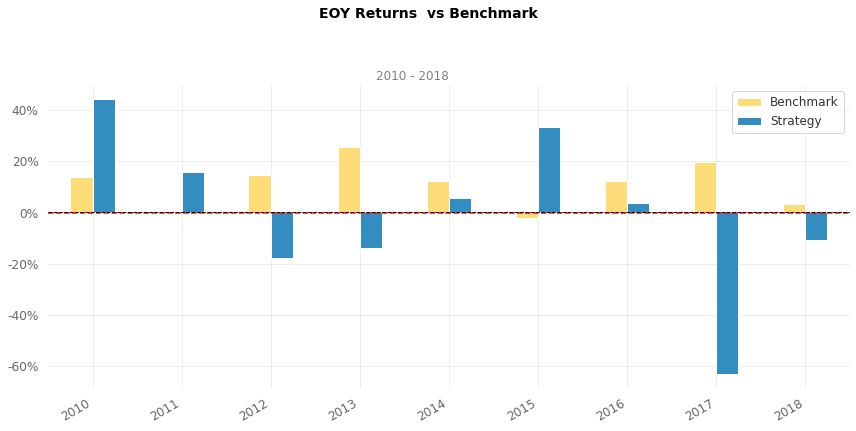

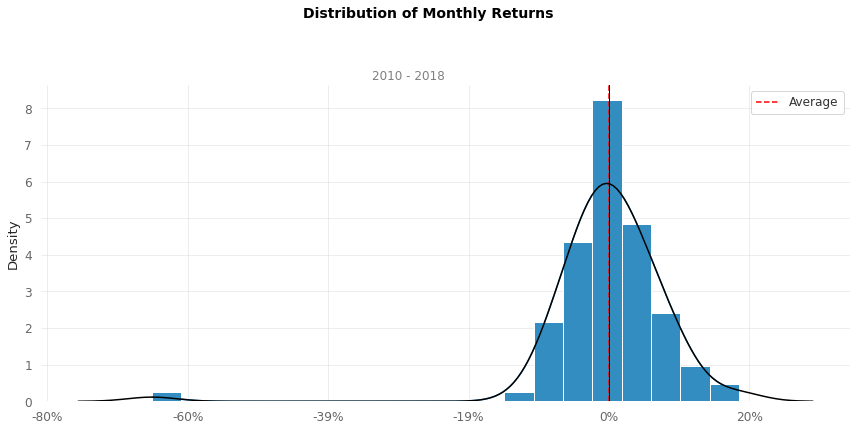

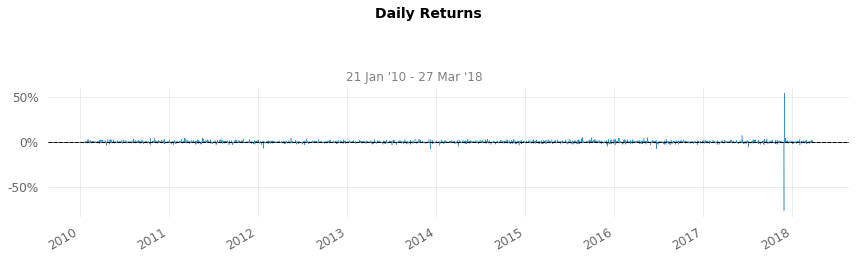

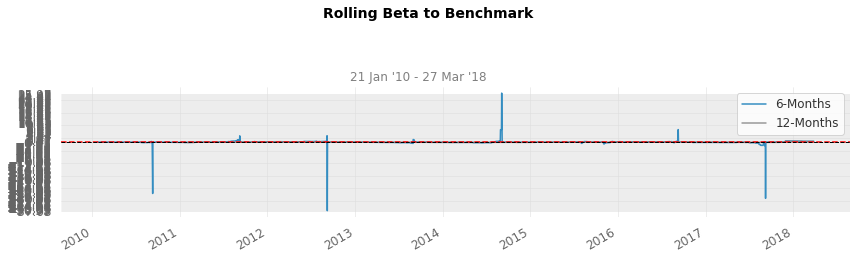

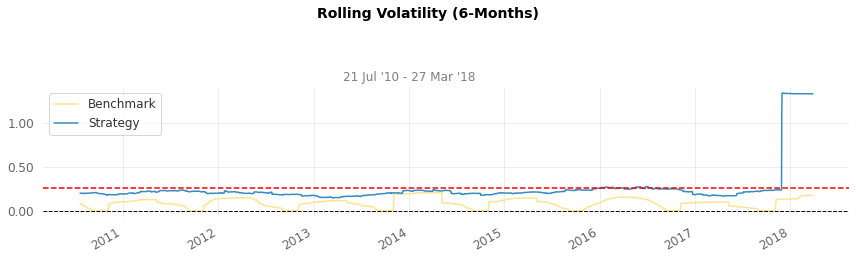

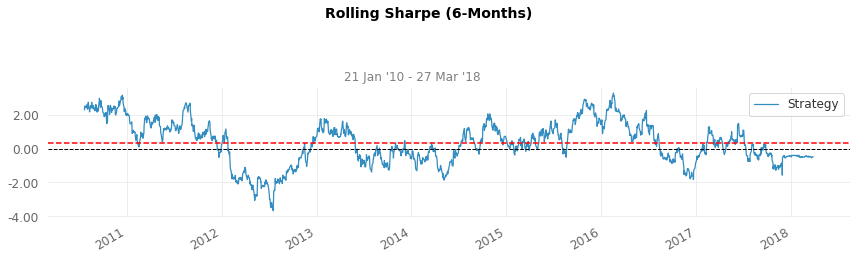

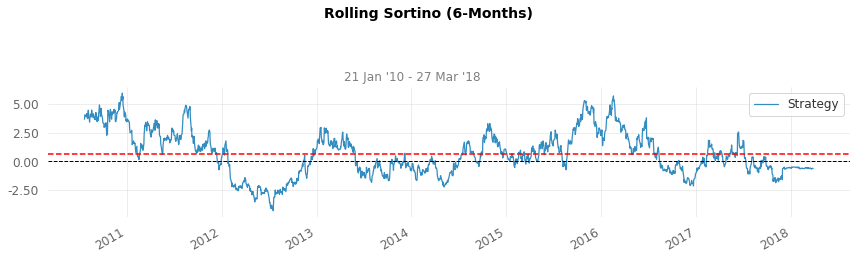

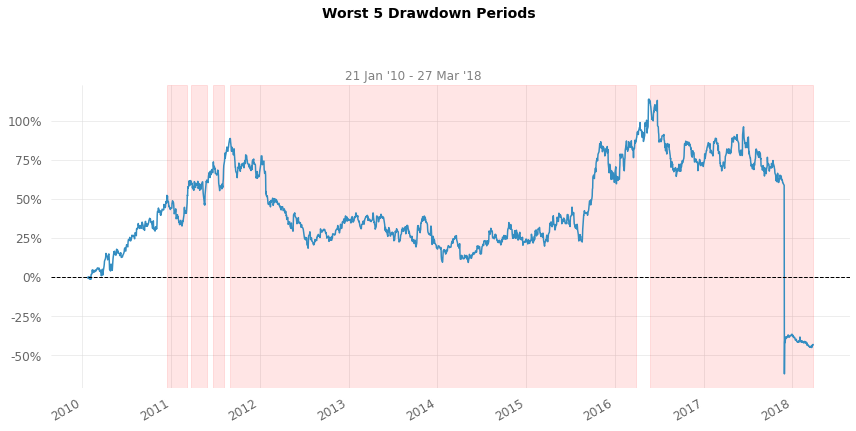

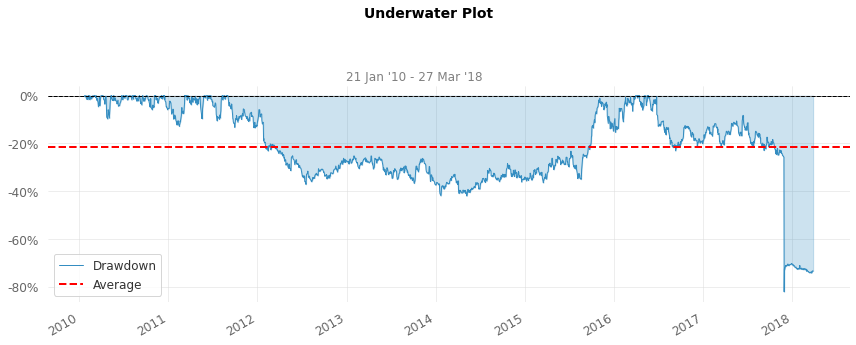

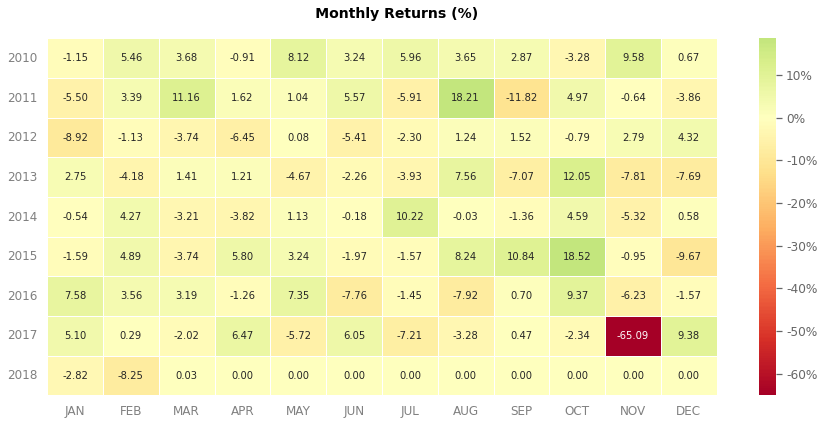

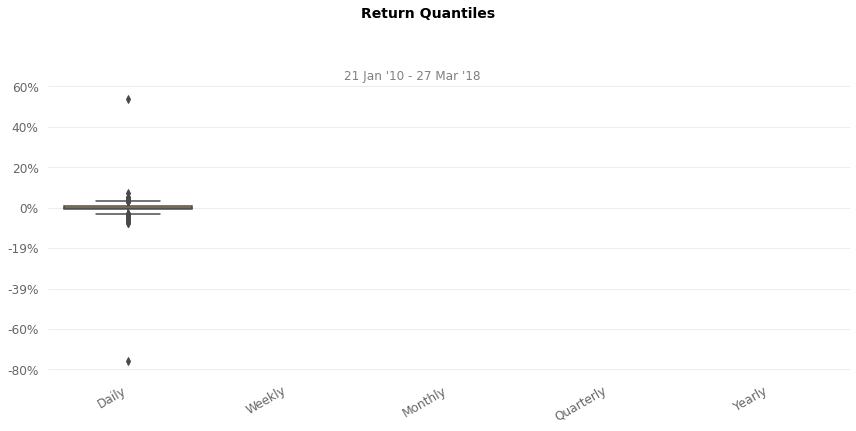

In [29]:
tearsheet = qs.reports.full(results['returns'], benchmark=benchmark, match_dates=True, figsize=(12, 6))

In [31]:
qs.reports.html(results['returns'], benchmark=benchmark, match_dates=True, figsize=(12, 6), output='factor1_tearsheet.html')

In [17]:
results.to_csv('/home/mehedi/Downloads/quant_pca-main/result20.csv',index=False)

OSError: Cannot save file into a non-existent directory: '/home/mehedi/Downloads/quant_pca-main'

In [ ]:
results.to_csv('/home/mehedi/Downloads/quant_pca-main/result21.csv',index=False)

                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2010-01-21  2010-01-21
End Period                 2018-03-27  2018-03-27
Risk-Free Rate             0.0%        0.0%
Time in Market             100.0%      35.0%

Cumulative Return          -43.32%     149.27%
CAGR﹪                     -6.7%       11.81%

Sharpe                     0.12        1.09
Prob. Sharpe Ratio         63.12%      99.99%
Smart Sharpe               0.09        0.78
Sortino                    0.16        2.06
Smart Sortino              0.11        1.47
Sortino/√2                 0.11        1.46
Smart Sortino/√2           0.08        1.04
Omega                      1.04        1.04

Max Drawdown               -82.14%     -13.73%
Longest DD Days            1671        616
Volatility (ann.)          38.79%      10.73%
R^2                        0.0         0.0
Information Ratio          -0.01       -0.01
Calmar                     -0.08      

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2016-05-23,2017-11-28,2018-03-27,673,-82.142183,-74.098314
2,2011-09-01,2014-05-07,2016-03-29,1671,-42.017738,-40.760776
3,2010-12-15,2011-02-14,2011-03-08,83,-12.861669,-12.298286
4,2011-06-24,2011-07-19,2011-08-08,45,-10.580047,-9.913497
5,2010-04-08,2010-04-26,2010-05-10,32,-9.739059,-9.406594


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


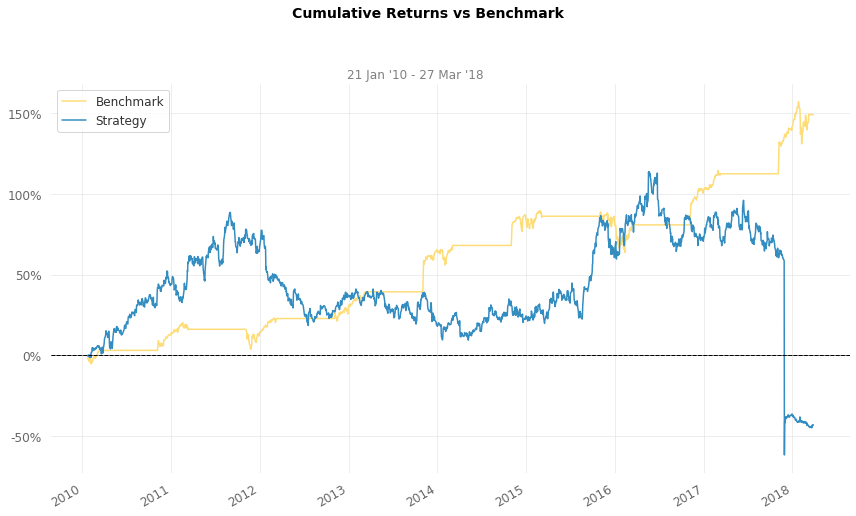

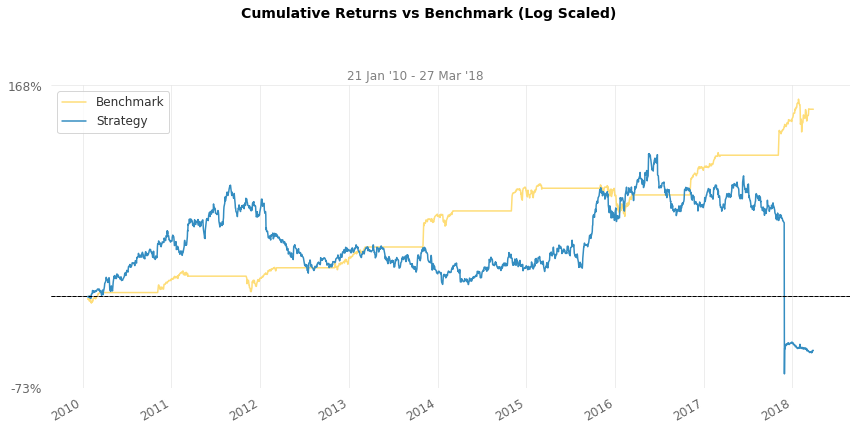

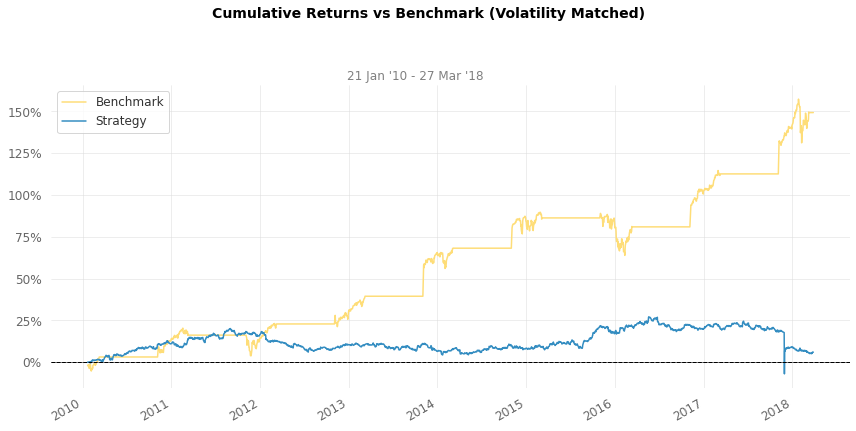

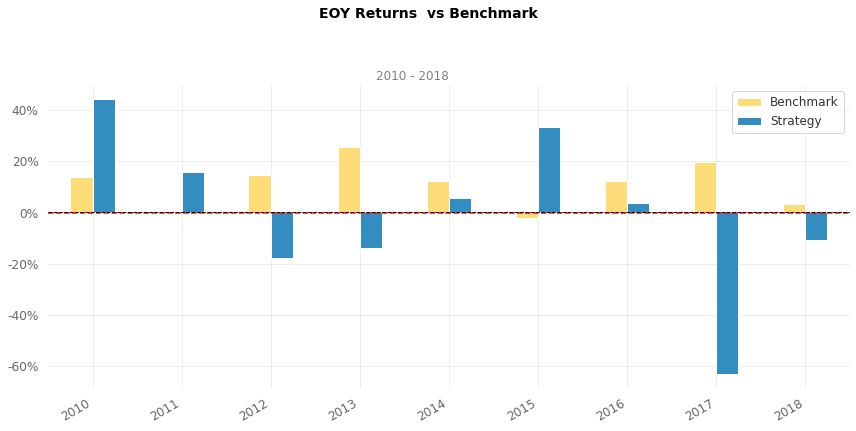

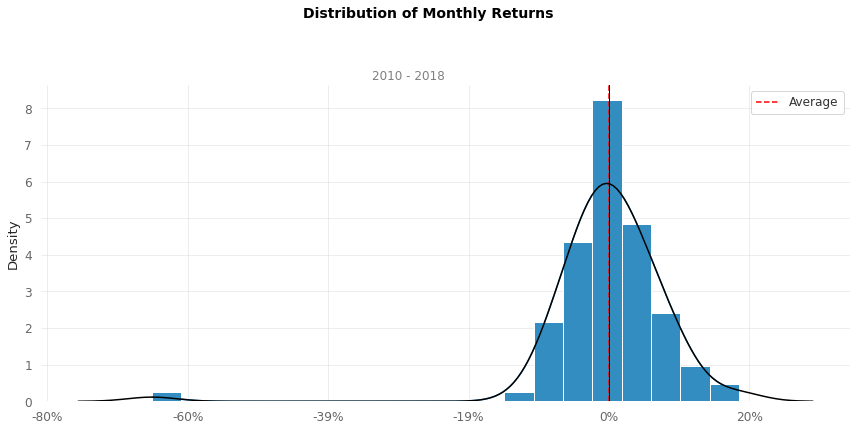

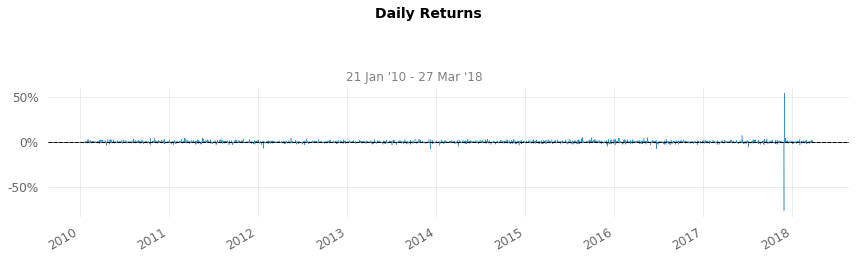

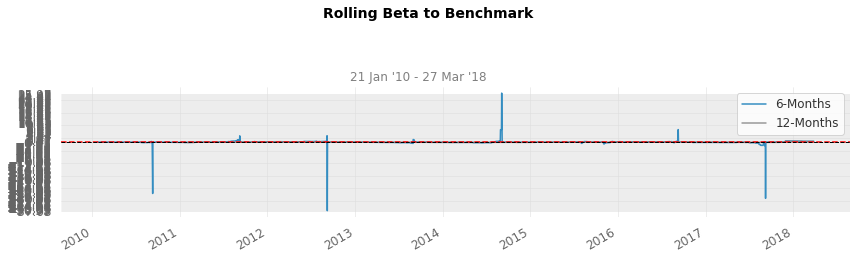

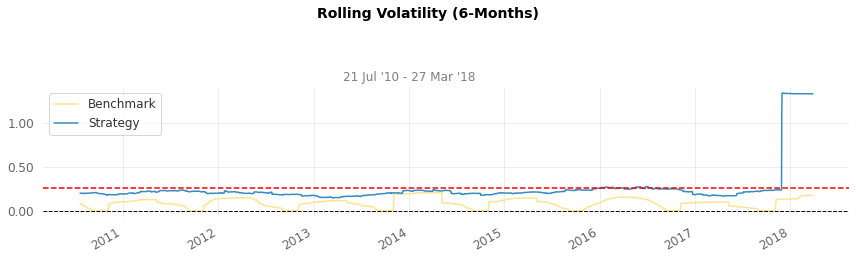

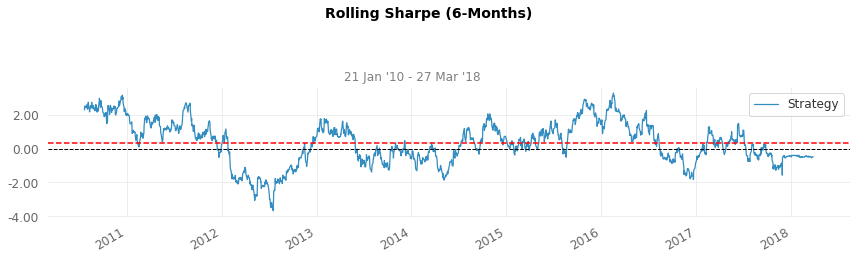

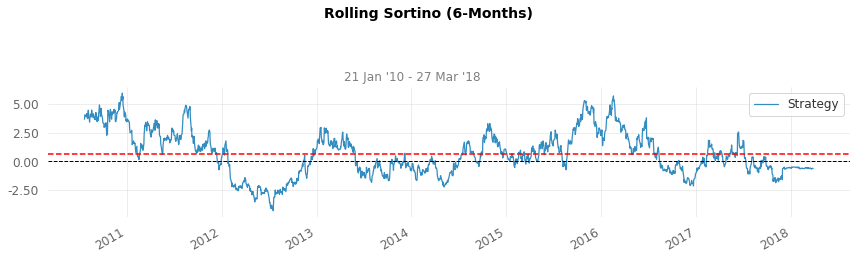

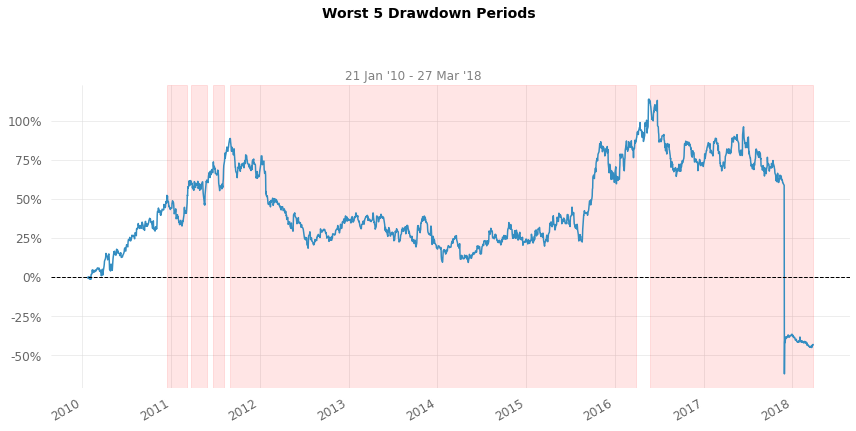

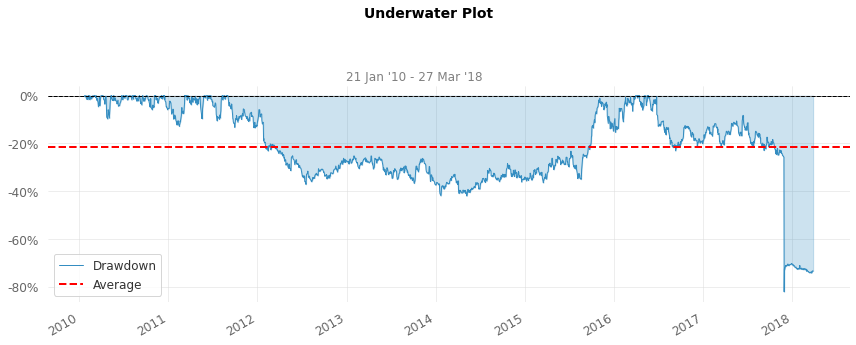

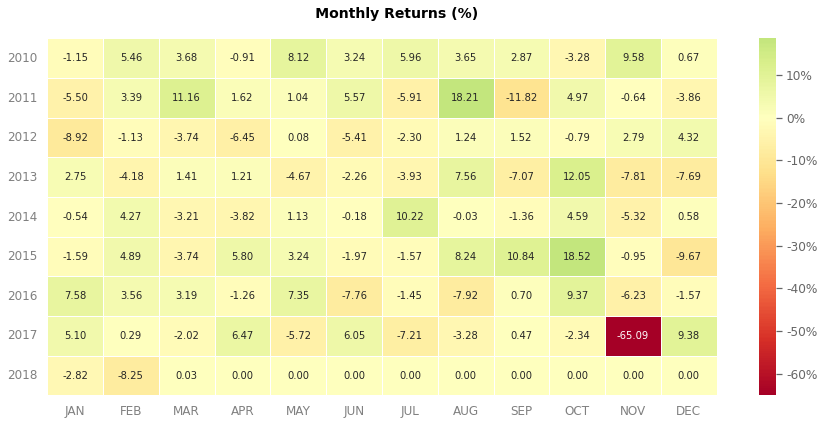

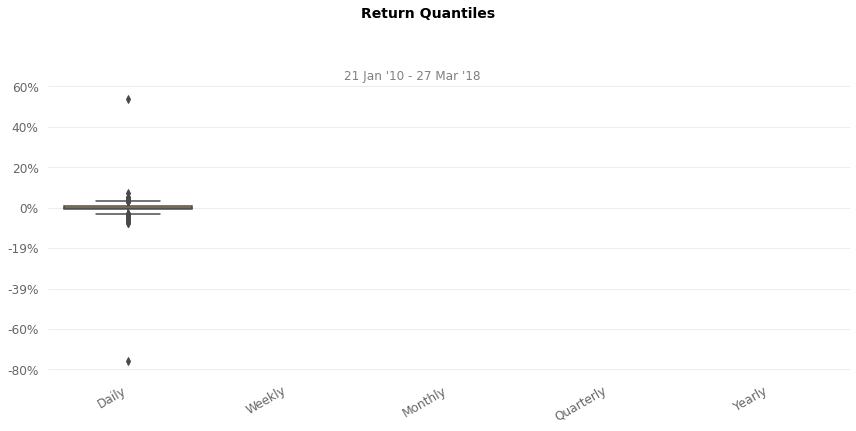

In [19]:
benchmark = qs.utils.download_returns('^GSPC', period="max")
results.index = pd.to_datetime(results.index).tz_convert(None)
a=qs.reports.full(results['returns'], benchmark = benchmark, match_dates=True, figsize=(12, 6))

In [ ]:
def calculate_atr(high_prices, low_prices, close_prices, period=14):
    high_low_diff = high_prices - low_prices
    high_close_diff = np.abs(high_prices - np.roll(close_prices, 1))
    low_close_diff = np.abs(low_prices - np.roll(close_prices, 1))
    true_range = np.maximum(high_low_diff, high_close_diff, low_close_diff)
    atr = np.mean(true_range[:period])
    for i in range(period, len(true_range)):
        atr = ((period - 1) * atr + true_range[i]) / period
    return atr

In [ ]:
def initialize(context):
    context.csv = pd.read_csv('/home/mehedi/Documents/PCA/quant_pca-main/factor1_baskets.csv')
    context.idx = 0
    context.longs = context.csv.longs.apply(ast.literal_eval).values
    context.shorts = context.csv.shorts.apply(ast.literal_eval).values
    context.stop_losses = {}
    context.take_profits = {}
    context.actions = []  # List to store trade actions
    context.long = 0
    context.short = 0
    context.stop_loss = 0
    context.take_profit = 0
    context.atr_window = 14
    context.long, context.short, context.stops, context.profits = 0, 0, 0, 0

def handle_data(context, data):
   
    
    for long_stocks in context.longs[context.idx]:
        asset = symbol(long_stocks)
        order_target_percent(asset, 0.1)  # Buy 10% of portfolio value
        context.stop_losses[asset] = data.current(asset, 'price') * 0.98
        context.take_profits[asset] = data.current(asset, 'price') * 1.04
    
        context.long += 1
         
    for short_stocks in context.shorts[context.idx]:
        asset = symbol(short_stocks)
        order_target_percent(asset, -0.1)  # Sell short 10% of portfolio value
        context.stop_losses[asset] = data.current(asset, 'price') * 0.96   #working like take-profit
        context.take_profits[asset] = data.current(asset, 'price') * 1.02  #working like stoploss  
        
        context.short +=1
    
    for asset in context.portfolio.positions:
        current_price = data.current(asset, 'price')
        if asset in context.stop_losses and current_price <= context.stop_losses[asset]:
            order_target_percent(asset=asset, target=0)
            context.stop_loss +=1
            del context.stop_losses[asset]
            del context.take_profits[asset]
            
        if asset in context.take_profits and current_price >= context.take_profits[asset]:
            order_target_percent(asset=asset, target=0)
            context.take_profit +=1
            del context.stop_losses[asset]
            del context.take_profits[asset]
              
    #Added ATR
            for stocks in context.portfolio.positions:
                current_price = data.current(stocks, 'price')
                cost_basis = context.portfolio.positions[stocks].cost_basis
                amount = context.portfolio.positions[stocks].amount
                high = data.history(stocks, 'high', context.atr_window + 1, '1d')
                low = data.history(stocks, 'low', context.atr_window + 1, '1d')
                close = data.history(stocks, 'close', context.atr_window + 1, '1d')
                atr = calculate_atr(high, low, close, context.atr_window)
                if amount > 0:
                    if current_price >= cost_basis + (atr * 2):
                        order_target_percent(stocks, 0)
                        context.profits += 1
                    elif current_price < cost_basis - (atr * 2):
                        order_target_percent(stocks, 0)
                        context.stops += 1
                elif amount < 0:
                    if current_price >= cost_basis + (atr * 2):
                        order_target_percent(stocks, 0)
                        context.stops += 1
                    elif current_price <= cost_basis -  (atr * 2):
                        order_target_percent(stocks, 0)
                        context.profits += 1
    
    context.idx += 1
    print ('long =', context.long, 'short=', context.short, 'take-profit=', context.take_profit, 'stop_loss=', context.stop_loss)
    

start = '2010-01-20'
end = '2018-03-27'
capital_base = 100000

results = run_algorithm(
    start=pd.Timestamp(start, tz='utc'),
    end=pd.Timestamp(end, tz='utc'),
    initialize=initialize,
    handle_data=handle_data,
    capital_base=capital_base,
    trading_calendar=calendar,
    bundle=bundle,
    data_frequency='daily'
)


long = 5 short= 5 take-profit= 0 stop_loss= 0
long = 10 short= 10 take-profit= 0 stop_loss= 0
long = 15 short= 15 take-profit= 0 stop_loss= 4
long = 20 short= 20 take-profit= 0 stop_loss= 5
long = 25 short= 25 take-profit= 0 stop_loss= 9
long = 30 short= 30 take-profit= 1 stop_loss= 9
long = 35 short= 35 take-profit= 1 stop_loss= 10
long = 40 short= 40 take-profit= 2 stop_loss= 13
long = 45 short= 45 take-profit= 3 stop_loss= 13
long = 50 short= 50 take-profit= 5 stop_loss= 13
long = 55 short= 55 take-profit= 6 stop_loss= 14
long = 60 short= 60 take-profit= 6 stop_loss= 30
long = 65 short= 65 take-profit= 7 stop_loss= 30
long = 70 short= 70 take-profit= 7 stop_loss= 30
long = 75 short= 75 take-profit= 9 stop_loss= 31
long = 80 short= 80 take-profit= 12 stop_loss= 31
long = 85 short= 85 take-profit= 16 stop_loss= 31
long = 90 short= 90 take-profit= 20 stop_loss= 31
long = 95 short= 95 take-profit= 24 stop_loss= 31
long = 100 short= 100 take-profit= 28 stop_loss= 31
long = 105 short= 105

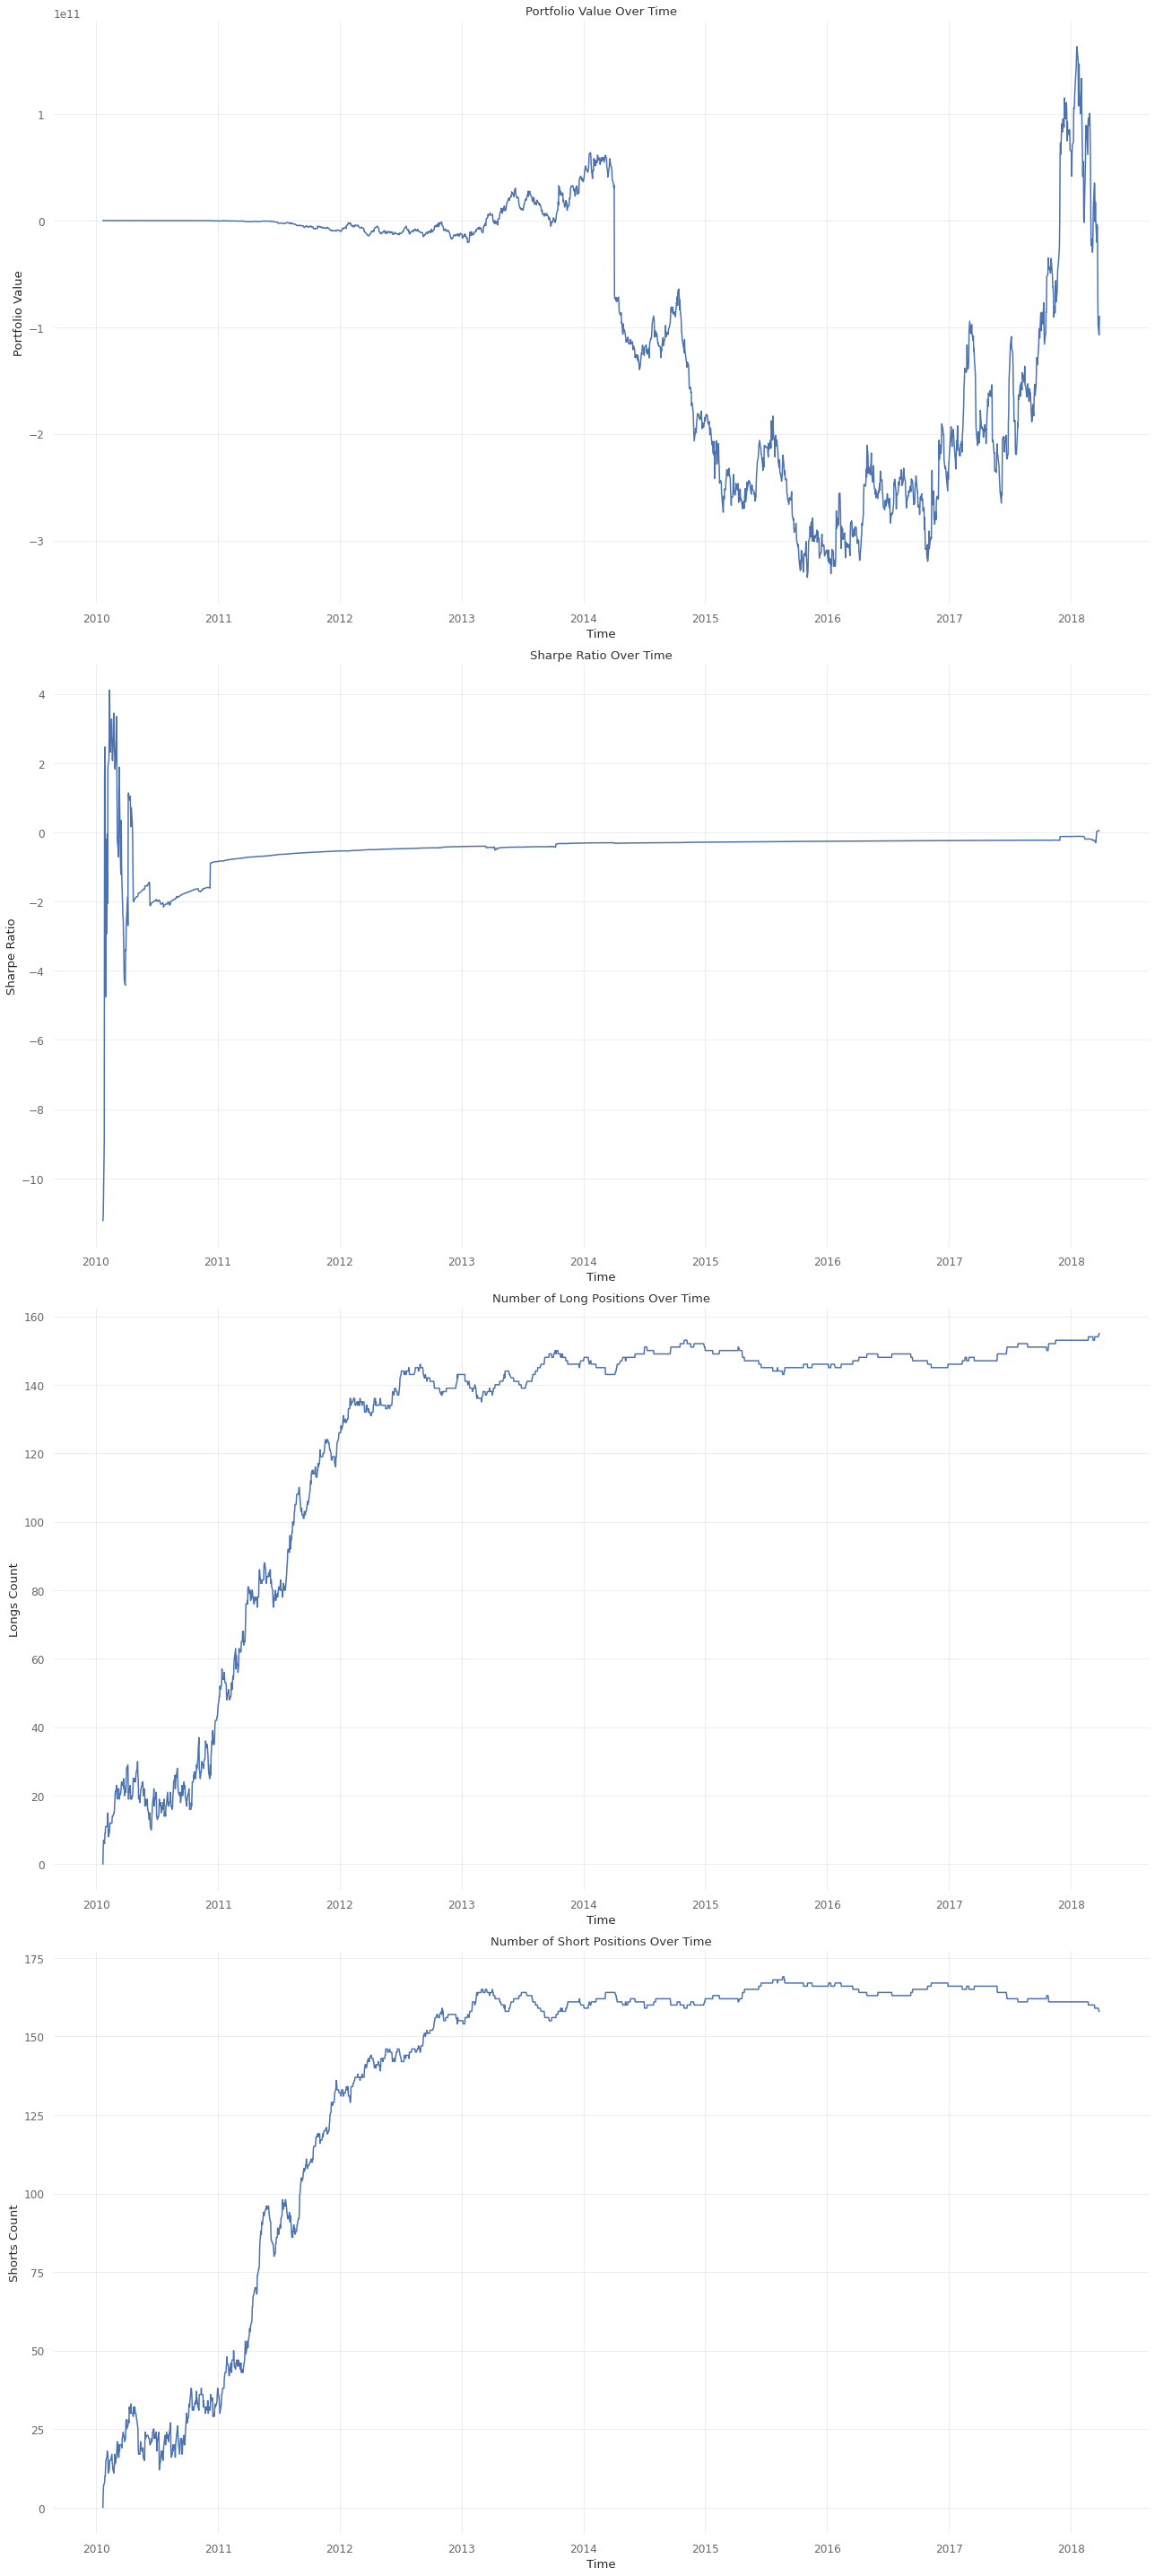

In [ ]:
abc(results)

In [ ]:
results.to_csv('/home/mehedi/Documents/PCA/quant_pca-main/Results from Backtest/result25.csv',index=False)